In [13]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

from utils.data_loader import EEGDataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [14]:
class DeepMLP(nn.Module):
    def __init__(self, input_size=95, num_classes=2, dropout_rate=0.3):
        super(DeepMLP, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1),
            nn.Dropout(dropout_rate)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Dropout(dropout_rate)
        )
        self.layer3 = nn.Sequential(
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        self.output = nn.Linear(64, num_classes)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.output(x)
        return x

In [15]:
class EEGDataset(Dataset):
    def __init__(self, X, y, scaler=None, fit_scaler=False):
        self.labels = y
        self.features = X.values.astype(np.float32)
        
        if fit_scaler:
            self.scaler = StandardScaler()
            self.features = self.scaler.fit_transform(self.features)
        elif scaler is not None:
            self.scaler = scaler
            self.features = self.scaler.transform(self.features)
        else:
            self.scaler = None

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return torch.tensor(self.features[idx]), torch.tensor(self.labels[idx], dtype=torch.long)

In [16]:
def train_one_fold(train_idx, val_idx, test_idx, X, y, groups, task_name, n_epochs=30, batch_size=64, lr=0.0001):
    # Prepare datasets
    X_train, y_train = X.iloc[train_idx], y[train_idx]
    X_val, y_val = X.iloc[val_idx], y[val_idx]
    X_test, y_test = X.iloc[test_idx], y[test_idx]
    
    train_dataset = EEGDataset(X_train, y_train, fit_scaler=True)
    val_dataset = EEGDataset(X_val, y_val, scaler=train_dataset.scaler)
    test_dataset = EEGDataset(X_test, y_test, scaler=train_dataset.scaler)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize model
    model = DeepMLP(input_size=95, num_classes=2).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    
    # Training loop with best model tracking
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_model_state = None
    
    for epoch in range(n_epochs):
        # Train
        model.train()
        epoch_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        train_losses.append(epoch_loss / len(train_loader))
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict().copy()
    
    # Load best model for evaluation
    model.load_state_dict(best_model_state)
    
    # Test evaluation with subject-level voting
    model.eval()
    y_pred_epochs = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            y_pred_epochs.extend(predicted.cpu().numpy())
    
    # Subject-level voting
    test_groups = groups[test_idx]
    results_df = pd.DataFrame({
        'Subject_ID': test_groups,
        'True_Label': y_test,
        'Pred_Label': y_pred_epochs
    })
    
    subj_true = []
    subj_pred = []
    for subject in results_df['Subject_ID'].unique():
        subj_data = results_df[results_df['Subject_ID'] == subject]
        true_lab = subj_data['True_Label'].iloc[0]
        pred_lab = subj_data['Pred_Label'].mode()[0]
        subj_true.append(true_lab)
        subj_pred.append(pred_lab)
    
    # Calculate metrics
    cm = confusion_matrix(subj_true, subj_pred)
    acc = accuracy_score(subj_true, subj_pred) * 100
    f1 = f1_score(subj_true, subj_pred) * 100
    
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        sens = (tp / (tp + fn) * 100) if (tp + fn) > 0 else 0
        spec = (tn / (tn + fp) * 100) if (tn + fp) > 0 else 0
    else:
        sens = spec = 0
    
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'best_val_loss': best_val_loss,
        'cm': cm,
        'acc': acc,
        'sens': sens,
        'spec': spec,
        'f1': f1
    }

In [17]:
# Load data
loader = EEGDataLoader(data_dir='../features')
X, y, groups = loader.get_data(task='AD_vs_CN')

# Run 5-fold cross-validation
results = []
for fold, (train_idx, val_idx, test_idx) in enumerate(loader.get_dl_kfold_indices(X, y, groups, n_splits=5)):
    print(f"\nTraining Fold {fold+1}...")
    result = train_one_fold(train_idx, val_idx, test_idx, X, y, groups, "AD_vs_CN", n_epochs=30, lr=0.0001)
    results.append(result)
    print(f"Fold {fold+1} - ACC: {result['acc']:.2f}%, SENS: {result['sens']:.2f}%, SPEC: {result['spec']:.2f}%, F1: {result['f1']:.2f}%")

Loading data from ../features...
  AD: 14514 samples
  FTD: 8262 samples
  CN: 12012 samples

Total: 34788 samples, 95 features
Class distribution: AD=14514, FTD=8262, CN=12012
Unique subjects: 88
Data loaded successfully!


Training Fold 1...
Fold 1 - ACC: 69.23%, SENS: 80.00%, SPEC: 62.50%, F1: 66.67%

Training Fold 2...
Fold 2 - ACC: 84.62%, SENS: 100.00%, SPEC: 80.00%, F1: 75.00%

Training Fold 3...
Fold 3 - ACC: 85.71%, SENS: 87.50%, SPEC: 83.33%, F1: 87.50%

Training Fold 4...
Fold 4 - ACC: 69.23%, SENS: 66.67%, SPEC: 71.43%, F1: 66.67%

Training Fold 5...
Fold 5 - ACC: 75.00%, SENS: 85.71%, SPEC: 60.00%, F1: 80.00%


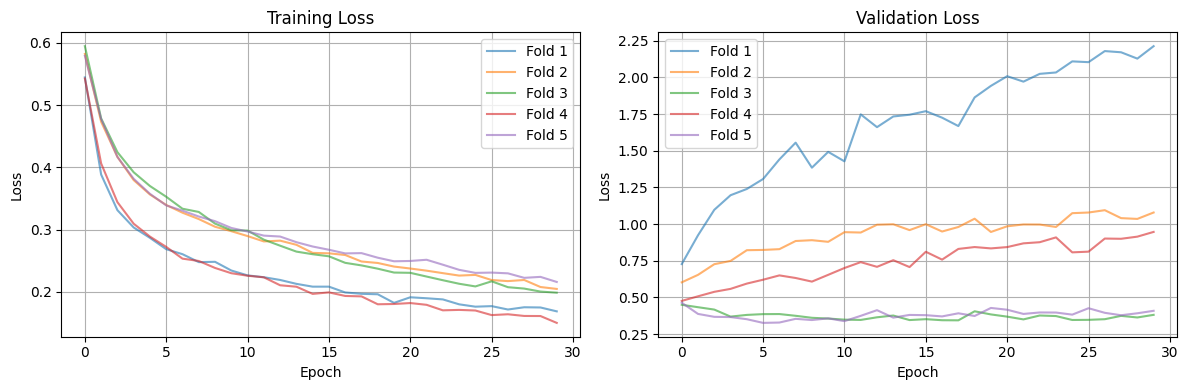

In [20]:
# Plot loss curves
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss curves for all folds
for i, result in enumerate(results):
    axes[0].plot(result['train_losses'], label=f'Fold {i+1}', alpha=0.6)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].legend()
axes[0].grid(True)

for i, result in enumerate(results):
    axes[1].plot(result['val_losses'], label=f'Fold {i+1}', alpha=0.6)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Validation Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


Cross-Validation Results (Subject-level)
Accuracy:    76.76% ± 7.19%
Sensitivity: 83.98% ± 10.84%
Specificity: 71.45% ± 9.23%
F1 Score:    75.17% ± 8.00%


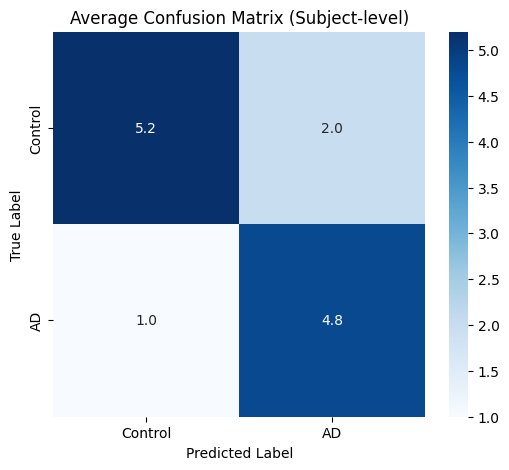

In [19]:
# Summary metrics
print("\n" + "="*50)
print("Cross-Validation Results (Subject-level)")
print("="*50)

accs = [r['acc'] for r in results]
sens_list = [r['sens'] for r in results]
spec_list = [r['spec'] for r in results]
f1s = [r['f1'] for r in results]

print(f"Accuracy:    {np.mean(accs):.2f}% ± {np.std(accs):.2f}%")
print(f"Sensitivity: {np.mean(sens_list):.2f}% ± {np.std(sens_list):.2f}%")
print(f"Specificity: {np.mean(spec_list):.2f}% ± {np.std(spec_list):.2f}%")
print(f"F1 Score:    {np.mean(f1s):.2f}% ± {np.std(f1s):.2f}%")

# Average confusion matrix
avg_cm = np.mean([r['cm'] for r in results], axis=0)
plt.figure(figsize=(6, 5))
sns.heatmap(avg_cm, annot=True, fmt='.1f', cmap='Blues', 
            xticklabels=['Control', 'AD'], yticklabels=['Control', 'AD'])
plt.title('Average Confusion Matrix (Subject-level)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()